In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None  

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Training_Data_0611N.csv")
df_train = df_train.iloc[:-4,:]
df_train.set_index("cust_id", inplace = True)
Y_train = df_train['profitable_flag']
df_train.drop('profitable_flag', axis=1, inplace=True)

# **Data Cleaning and precprocessing**

In [4]:
# First, we will seggregate numerical and object columns, to be processed separately

columns_object = []
columns_float = []
for column in df_train.columns:
  if df_train[column].dtype == 'O':
    columns_object.append(column)
  else:
    columns_float.append(column)

# Also in object columns, the three underneath are categorical, and rest can e converted to their indiviual float values
columns_object.remove('acq_sub_chn')
columns_object.remove('acq_type_grp')
columns_object.remove('fee_type_grp')

columns_cat = ['acq_sub_chn', 'acq_type_grp', 'fee_type_grp']

In [5]:
# Replacing "-" values in object columns with nan values
df_train = df_train.replace(to_replace = "-", value = np.nan)
df_train = df_train.replace(to_replace = ' -   ', value = np.nan)


# Mapping the numerical object columns to float values
def mapping_to_float(x):
  try:  
    x = x.split("(")[-1].split(")")[0]
    try:
      temp = x.split(" ")[1]
    except:
      temp = x
  except:
    temp = x
    return temp
  return float(re.sub(",", "", temp))

for column in columns_object:
  df_train[column] = df_train[column].apply(mapping_to_float)
  print(df_train[column].dtype)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


In [6]:
for column in columns_object:
  if df_train[column].isna().sum() > (0.3)*df_train.shape[0]:
    print(df_train[column].isna().sum())
    
for column in columns_float:
  if df_train[column].isna().sum() > (0.3)*df_train.shape[0]:
    print(df_train[column].isna().sum())

15448
10557
16492
13909


In [7]:
# A lot of columns have more then 30% of the values as nan, and need to be dropped

for column in columns_object:
  if df_train[column].isna().sum() > (0.3)*df_train.shape[0]:
    print(df_train[column].isna().sum())
    df_train.drop(column, axis=1, inplace=True)
    columns_object.remove(column)

for column in columns_float:
  if df_train[column].isna().sum() > (0.3)*df_train.shape[0]:
    print(df_train[column].isna().sum())
    df_train.drop(column, axis=1, inplace=True)
    columns_object.remove(column)


for column in columns_cat:
  if df_train[column].isna().sum() > (0.3)*df_train.shape[0]:
    print(df_train[column].isna().sum())
    df_train.drop(column, axis=1, inplace=True)
    columns_object.remove(column)


# Now lets make two major categories, one for numerical and one for categrocial columns

df_numr = df_train[columns_float + columns_object]
df_cat = df_train[columns_cat]

15448
16492


## **(1) Correcting Outliers**

#### **Only for numerical rows**

In [8]:
# As is clearly visible, our data is ridden with outliers, we will need check the percentage of data as outliers 

for column in df_numr.columns:
    q1 = np.nanpercentile(df_numr[column], 25)
    q3 = np.nanpercentile(df_numr[column], 75)

    iqr = q3 - q1

    lower = q1 - 2*iqr
    upper = q3 + 2*iqr

    temp_1 = df_numr[column] < lower
    temp_2 = df_numr[column] > upper

    temp = temp_1 | temp_2

    print("Percentage of outliers in " + column + " is " + str((temp.sum() / df_numr.shape[0])*100))


Percentage of outliers in count_accts is 18.958918091349833
Percentage of outliers in cm_age is 1.1380454197499361
Percentage of outliers in flag_top_ed_spender is 0.0
Percentage of outliers in flag_cust_fee_paid_6m is 24.210257718805817
Percentage of outliers in pre6m_cust_roc_cnt is 0.8063281449349323
Percentage of outliers in pre6m_cust_non_disc_cnt is 1.1839755039550905
Percentage of outliers in pre6m_cust_disc_cnt is 1.709619800969635
Percentage of outliers in pre6m_cust_online_cnt is 3.016075529471804
Percentage of outliers in pre6m_cust_travel_cnt is 5.46568002041337
Percentage of outliers in pre6m_cust_retail_cnt is 1.143148762439398
Percentage of outliers in pre6m_cust_myca_active is 1.6892064302117888
Percentage of outliers in pre6m_cust_mob_logins is 11.78872161265629
Percentage of outliers in Cust_tenure is 7.108956366420005
Percentage of outliers in pre6m_spend_active_ind is 6.619035468231692
Percentage of outliers in highly_utilized_ind is 7.4406736412350085
Percentage of

In [9]:
# Hence, a lot of columns have a great percentage of outliers, hence, we cant just drop outliers there
# As is clearly visible, our data is ridden with outliers, we will need check the percentage of data as outliers 

for column in df_numr.columns:
  if len(df_numr[column].unique().tolist()) > 50:
    q1 = np.nanpercentile(df_numr[column], 25)
    q3 = np.nanpercentile(df_numr[column], 75)

    iqr = q3 - q1

    lower = q1 - 2*iqr
    upper = q3 + 2*iqr

    temp_1 = df_numr[column] < lower
    temp_2 = df_numr[column] > upper

    temp = temp_1 | temp_2

    # If not, the the outliers will be replaced with the maximum or minimum values respectively
    temp_new = df_numr[column] < lower
    df_numr[column][list(temp_new.loc[temp_new == True].index)] = lower

    temp_new = df_numr[column] > upper
    df_numr[column][list(temp_new.loc[temp_new == True].index)] = upper

    assert df_numr[column].max() <= upper
    assert df_numr[column].min() >= lower

print(df_numr.shape)

(19595, 43)


In [10]:
# upon deeper analysis, one can see that most of the values of sow_revol_avg_paydown_pct column is 0, adn after removing outliers has become all 0s. Hence is redundant and can be dropped
df_numr.drop('sow_revol_avg_paydown_pct', axis=1, inplace=True)

## **(2) Filling Nan Values**

In [11]:
# Once the outliers are removed, we can simply impute the nan values from any central tendency (say mean) for numerical rows

for column in df_numr.columns:
  df_numr[column].fillna(df_numr[column].mean(), inplace = True)
print(df_numr.shape)

(19595, 42)


In [12]:
# Check for the number of nan values in categorical column

for column in df_cat.columns:
  print(df_cat[column].isna().sum())

902
872
0


In [13]:
# Imputting the Nan values here will happend on the same probability distribution as the values are distributed
leng = df_cat.shape[0]

for column in df_cat.columns:
  temp = df_cat[column].unique().tolist()
  temp = np.asarray(temp)

  prob_dist = []
  for element in temp:
    prob_dist.append(df_cat[df_cat[column] == element].shape[0] / leng)

  # We need to make sure that probab dist adds to one;
  to_change = 1 - sum(prob_dist)
  max_idx = prob_dist.index(max(prob_dist))

  # adding the change to max_prob :-
  prob_dist[max_idx] = to_change + prob_dist[max_idx]

  idx = df_cat[df_cat[column].isna() == True].index

  for i in idx:
    x = np.random.choice(temp, size = None, p = prob_dist)
    
    # Chances are that again nan is imputed for nan, hence, to remove that :-
    while x == np.nan:
      x = np.random.choice(temp, size = None, p = prob_dist)
    df_cat[column][i] = x
print(df_cat.isna().sum())

acq_sub_chn     0
acq_type_grp    0
fee_type_grp    0
dtype: int64


In [14]:
# Sanity Check

for column in df_numr.columns:
  assert df_numr[column].isna().sum() == 0
  assert df_numr[column].isnull().sum() == 0

for column in df_cat.columns:
  assert df_cat[column].isna().sum() == 0
  assert df_cat[column].isnull().sum() == 0

## (3) **Dummy variables, and restricting it to avoid dimensionality rediction**

In [15]:
# # We know, the first categorical variable has a lot of differnet values, and can be directy converted to dummy, or else sparsness will inc
# # While forming one-hot encoding data, adding 23 new columns will cause sparseness. We will just take the 10 most common categories to form dummy columns

# # Variable counts arranged in sorted form
# df_cat[df_cat.columns[0]].value_counts().sort_values(ascending=False).head(20)

# top_10 = [x for x in df_cat[df_cat.columns[0]].value_counts().sort_values(ascending=False).head(10).index]
# top_10

# df_cat_1 = pd.DataFrame()

# for label in top_10:
#   df_cat_1[label] = np.where(df_cat[df_cat.columns[0]] == label, 1, 0)

# df_cat_1 = df_cat_1.set_index(df_cat.index)
# df_cat_1[top_10].head(40)

In [16]:
# df_cat_2 = pd.get_dummies(df_cat[df_cat.columns[1:]])

# # Therefore, final categorical df is :-

# df_cat_dummy = pd.concat([df_cat_1, df_cat_2], axis=1)
# print(df_cat_dummy.shape)

In [17]:
# """ Concatinating to form the final dataset """

# df_train = df_numr.join(df_cat_dummy)
# df_train = df_train.join(Y_train)
# print(df_train.shape)
# df_train

In [18]:
# df_train = df_numr.join(df_cat)
# df_train = df_train.join(Y_train)
# df_train.shape

## **Exploratory Data Analysis**

In [19]:
df_train = df_numr.join(df_cat)
df_train = df_train.join(Y_train)
df_train.shape

(19595, 46)

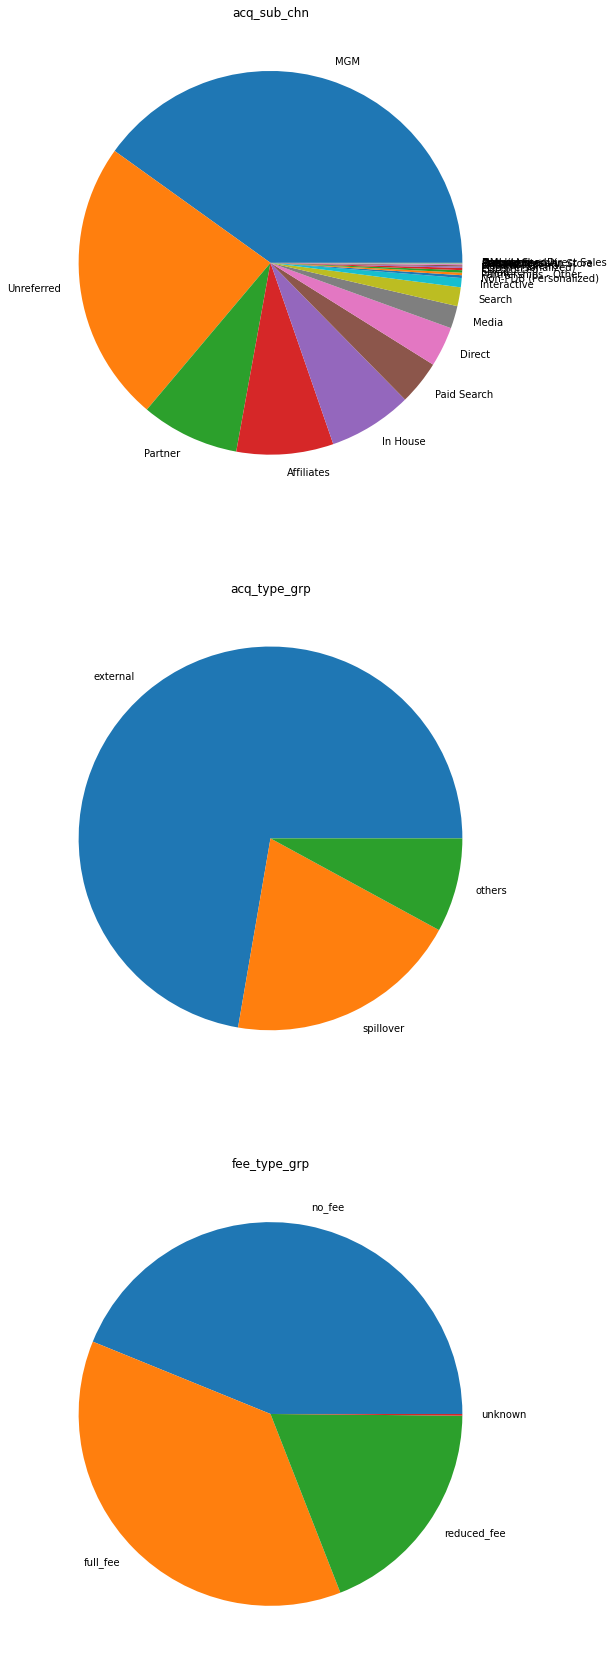

In [20]:
cat_cols = df_cat.columns

fig, axs = plt.subplots(nrows = len(cat_cols), ncols = 1, figsize = (15, 10*len(cat_cols)))

for i in range(len(cat_cols)):
  x = df_cat[cat_cols[i]].value_counts().sort_values(ascending = False)
  axs[i].pie(x, labels = list(x.to_frame().index))
  axs[i].set_title(cat_cols[i])
plt.show()

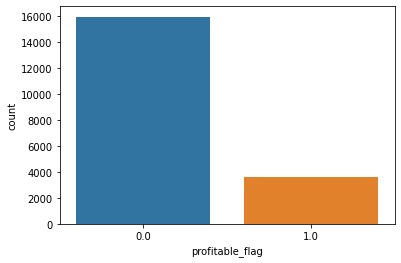

In [21]:
sns.countplot(x = 'profitable_flag', data = df_train)
plt.show()

# We can closely see 4:1 class ratio as negative:positive classes

In [22]:
# We know, the first categorical variable has a lot of differnet values, and can be directy converted to dummy, or else sparsness will inc
# While forming one-hot encoding data, adding 23 new columns will cause sparseness. We will just take the 10 most common categories to form dummy columns

# Variable counts arranged in sorted form
df_cat[df_cat.columns[0]].value_counts().sort_values(ascending=False).head(20)

top_10 = [x for x in df_cat[df_cat.columns[0]].value_counts().sort_values(ascending=False).head(10).index]
top_10

df_cat_1 = pd.DataFrame()

for label in top_10:
  df_cat_1[label] = np.where(df_cat[df_cat.columns[0]] == label, 1, 0)

df_cat_1 = df_cat_1.set_index(df_cat.index)
df_cat_1[top_10].head(40)

,MGM,Unreferred,Partner,Affiliates,In House,Paid Search,Direct,Media,Search,Interactive
cust_id,,,,,,,,,,
550391.0,0,1,0,0,0,0,0,0,0,0
550392.0,0,0,0,0,1,0,0,0,0,0
550393.0,0,1,0,0,0,0,0,0,0,0
550394.0,1,0,0,0,0,0,0,0,0,0
550395.0,0,0,0,1,0,0,0,0,0,0
550396.0,0,1,0,0,0,0,0,0,0,0
550397.0,0,1,0,0,0,0,0,0,0,0
550398.0,0,0,0,1,0,0,0,0,0,0
550399.0,1,0,0,0,0,0,0,0,0,0


In [23]:
df_cat_2 = pd.get_dummies(df_cat[df_cat.columns[1:]])

# Therefore, final categorical df is :-

df_cat_dummy = pd.concat([df_cat_1, df_cat_2], axis=1)
print(df_cat_dummy.shape)

(19595, 17)


In [24]:
""" Concatinating to form the final dataset """

df_train = df_numr.join(df_cat_dummy)
df_train = df_train.join(Y_train)
print(df_train.shape)
df_train

(19595, 60)


,count_accts,cm_age,flag_top_ed_spender,flag_cust_fee_paid_6m,pre6m_cust_roc_cnt,pre6m_cust_non_disc_cnt,pre6m_cust_disc_cnt,pre6m_cust_online_cnt,pre6m_cust_travel_cnt,pre6m_cust_retail_cnt,pre6m_cust_myca_active,pre6m_cust_mob_logins,Cust_tenure,pre6m_spend_active_ind,highly_utilized_ind,min_pay_ind,paid_in_full_ind,direct_debit_ind,referrals,spillover,self_accts,Customer Low Quality indicator,cdss_most_rcnt_prob,cbr_3_score,cnsumr_chrg_actv_cust_cnt,cnsumr_lend_actv_cust_cnt,cnsumr_lend_tot_util_ratio,sow_tot_revol_cnt,sow_tot_trans_cnt,pre6m_cust_spend,pre6m_cust_non_disc_amt,pre6m_cust_disc_amt,pre6m_cust_outbound_amt,pre6m_cust_online_amt,pre6m_cust_travel_amt,pre6m_cust_retail_amt,pre6m_total_mc_trs,sum_total_line_amt,cust_max_credit_12m_amt,cust_max_remit_12m_amt,sow_tot_annual_ext_pmt_amt,sow_tot_trans_bal_amt,MGM,Unreferred,Partner,Affiliates,In House,Paid Search,Direct,Media,Search,Interactive,acq_type_grp_external,acq_type_grp_others,acq_type_grp_spillover,fee_type_grp_full_fee,fee_type_grp_no_fee,fee_type_grp_reduced_fee,fee_type_grp_unknown,profitable_flag
cust_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
550391.0,1.0,74.0,1.0,0.0,122.0,96.0,26.0,36.0,2.0,98.0,9.0,48.0,63.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000,1376.0,0.0,1.0,0.034044,0.0,3.0,1518.0,811.0,707.0,740.383971,606.000000,28.00000,814.0,2.0,80000.0,482.000000,418.000000,991.000000,335.252198,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0
550392.0,1.0,64.0,0.0,0.0,354.0,82.0,272.0,456.0,44.0,116.0,0.0,0.0,99.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.000,1300.0,0.0,1.0,0.044086,2.0,0.0,4807.0,1052.0,3756.0,673.000000,3164.000000,2291.00000,1265.0,15.0,140000.0,2165.000000,2165.000000,2.000000,335.252198,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0.0
550393.0,1.0,75.0,1.0,0.0,204.0,118.0,86.0,152.0,0.0,166.0,9.0,18.0,99.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,1376.0,0.0,1.0,0.039613,0.0,3.0,2361.0,1351.0,1010.0,237.000000,693.000000,1427.33091,1623.0,20.0,32800.0,703.000000,687.000000,4828.000000,387.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0
550394.0,2.0,73.0,0.0,1.0,142.0,50.0,92.0,64.0,54.0,54.0,9.0,23.0,99.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000,1372.0,1.0,1.0,0.001200,0.0,4.0,5452.0,1195.0,4257.0,803.000000,1618.000000,2760.00000,1605.0,30.0,100000.0,1225.000000,1225.000000,4598.000000,295.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0
550395.0,2.0,68.0,0.0,0.0,34.0,20.0,14.0,4.0,0.0,18.0,0.0,0.0,99.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.001,1338.0,0.0,2.0,0.003378,5.0,13.0,170.0,88.0,82.0,10.000000,10.000000,1427.33091,66.0,9.0,20800.0,51.000000,35.000000,2176.000000,143.000000,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569981.0,1.0,33.0,0.0,0.0,422.0,144.0,278.0,292.0,2.0,224.0,5.0,5.0,18.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000,1239.0,0.0,1.0,0.028450,0.0,0.0,3667.0,1730.0,1938.0,359.000000,969.000000,170.00000,1593.0,16.0,25333.0,1799.000000,1799.000000,4122.966696,335.252198,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1.0
569982.0,1.0,71.0,0.0,0.0,118.0,86.0,32.0,0.0,6.0,86.0,6.0,16.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003,1137.0,0.0,1.0,0.175549,2.0,0.0,2441.0,973.0,1468.0,1274.000000,2068.103596,13.00000,973.0,49.0,40000.0,1683.000000,83.000000,692.000000,335.252198,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0.0
569983.0,1.0,48.0,1.0,0.0,76.0,32.0,44.0,4.0,28.0,34.0,4.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003,1027.0,0.0,1.0,0.215851,0.0,0.0,1387.0,169.0,1219.0,740.383971,1011.000000,1086.00000,209.0,26.0,6667.0,1616.288341,1541.352868,4122.966696,335.252198,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0


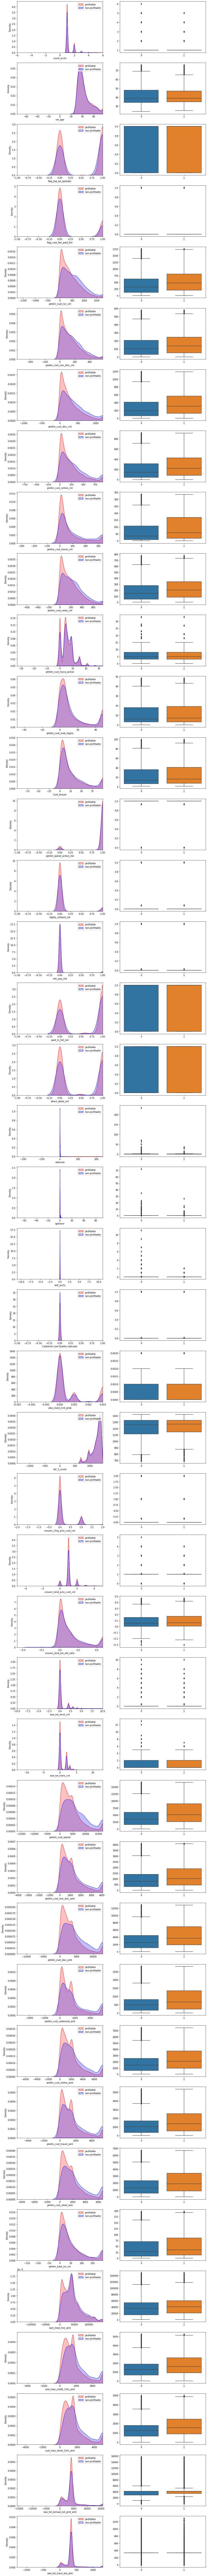

In [25]:
numr_cols = list(df_numr.columns)
cat_cols = list(df_cat.columns)


fig, axs = plt.subplots(nrows = len(numr_cols), ncols = 2, figsize = (15, 5*len(numr_cols)))
for i in range(len(numr_cols)):

  df_temp_1 = df_train[df_train['profitable_flag'] == 1.0]
  df_temp_0 = df_train[df_train['profitable_flag'] == 0.0]

  sns.kdeplot(ax = axs[i][0], x = df_temp_0[numr_cols[i]], shade=True, color = 'r')
  sns.kdeplot(ax = axs[i][0], x = df_temp_1[numr_cols[i]], shade=True, color = 'b')
  axs[i][0].legend(['profitable', 'non-profitable'])
  axs[i][0].set_xlim(-max(df_temp_0[numr_cols[i]].max(), df_temp_0[numr_cols[i]].max()), max(df_temp_0[numr_cols[i]].max(), df_temp_0[numr_cols[i]].max()))
  
  x_1 = df_temp_1[numr_cols[i]]
  y_1 = df_temp_1['profitable_flag']

  x_2 = df_temp_0[numr_cols[i]]
  y_2 = df_temp_0['profitable_flag']

  sns.boxplot(ax = axs[i][1], data = [df_temp_0[numr_cols[i]], df_temp_1[numr_cols[i]]])

plt.show()

### One can see that not a vast different is observed between the kdeplots of profitable and non-profitbale variables. Although, in some cases the curve for non-profitable ones seem to become a but more flatter

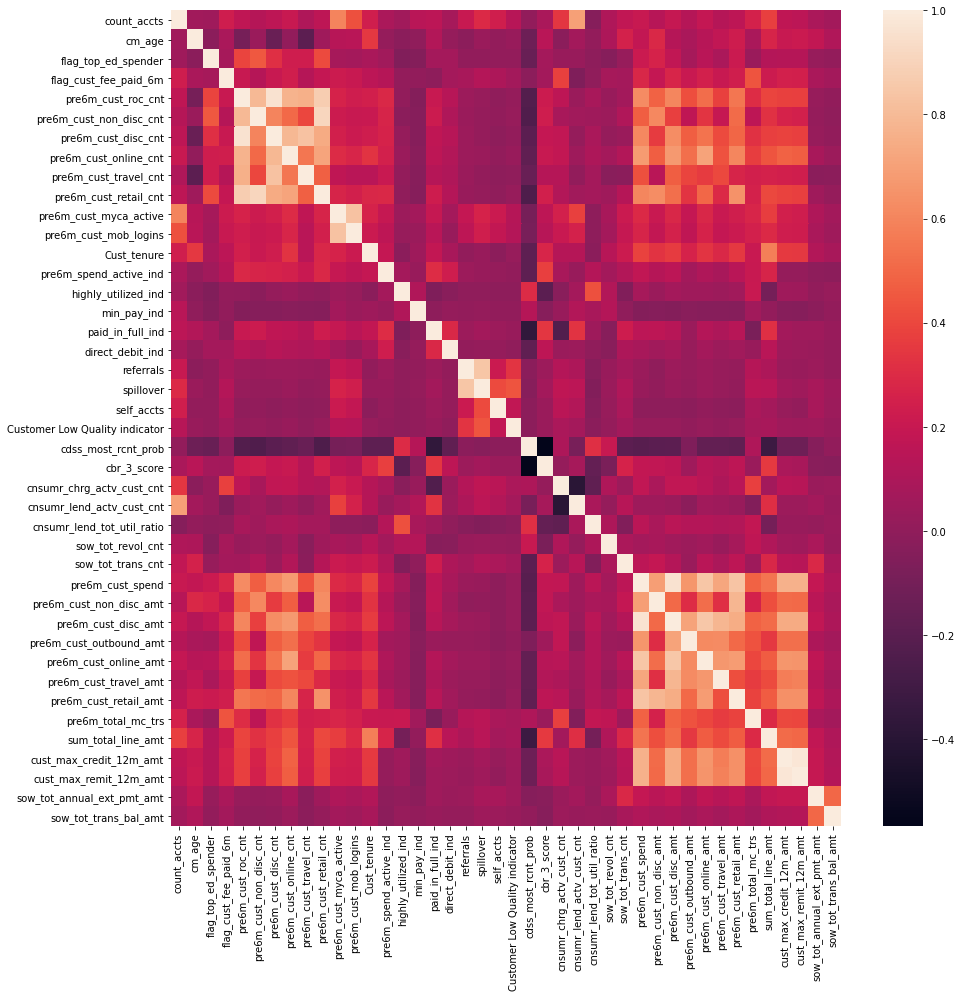

In [26]:
plt.figure(figsize = (15,15))
sns.heatmap(df_numr.corr())
plt.show()

# **Feature Selection**

In [27]:
df_train

,count_accts,cm_age,flag_top_ed_spender,flag_cust_fee_paid_6m,pre6m_cust_roc_cnt,pre6m_cust_non_disc_cnt,pre6m_cust_disc_cnt,pre6m_cust_online_cnt,pre6m_cust_travel_cnt,pre6m_cust_retail_cnt,pre6m_cust_myca_active,pre6m_cust_mob_logins,Cust_tenure,pre6m_spend_active_ind,highly_utilized_ind,min_pay_ind,paid_in_full_ind,direct_debit_ind,referrals,spillover,self_accts,Customer Low Quality indicator,cdss_most_rcnt_prob,cbr_3_score,cnsumr_chrg_actv_cust_cnt,cnsumr_lend_actv_cust_cnt,cnsumr_lend_tot_util_ratio,sow_tot_revol_cnt,sow_tot_trans_cnt,pre6m_cust_spend,pre6m_cust_non_disc_amt,pre6m_cust_disc_amt,pre6m_cust_outbound_amt,pre6m_cust_online_amt,pre6m_cust_travel_amt,pre6m_cust_retail_amt,pre6m_total_mc_trs,sum_total_line_amt,cust_max_credit_12m_amt,cust_max_remit_12m_amt,sow_tot_annual_ext_pmt_amt,sow_tot_trans_bal_amt,MGM,Unreferred,Partner,Affiliates,In House,Paid Search,Direct,Media,Search,Interactive,acq_type_grp_external,acq_type_grp_others,acq_type_grp_spillover,fee_type_grp_full_fee,fee_type_grp_no_fee,fee_type_grp_reduced_fee,fee_type_grp_unknown,profitable_flag
cust_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
550391.0,1.0,74.0,1.0,0.0,122.0,96.0,26.0,36.0,2.0,98.0,9.0,48.0,63.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000,1376.0,0.0,1.0,0.034044,0.0,3.0,1518.0,811.0,707.0,740.383971,606.000000,28.00000,814.0,2.0,80000.0,482.000000,418.000000,991.000000,335.252198,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0
550392.0,1.0,64.0,0.0,0.0,354.0,82.0,272.0,456.0,44.0,116.0,0.0,0.0,99.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.000,1300.0,0.0,1.0,0.044086,2.0,0.0,4807.0,1052.0,3756.0,673.000000,3164.000000,2291.00000,1265.0,15.0,140000.0,2165.000000,2165.000000,2.000000,335.252198,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0.0
550393.0,1.0,75.0,1.0,0.0,204.0,118.0,86.0,152.0,0.0,166.0,9.0,18.0,99.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,1376.0,0.0,1.0,0.039613,0.0,3.0,2361.0,1351.0,1010.0,237.000000,693.000000,1427.33091,1623.0,20.0,32800.0,703.000000,687.000000,4828.000000,387.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0
550394.0,2.0,73.0,0.0,1.0,142.0,50.0,92.0,64.0,54.0,54.0,9.0,23.0,99.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000,1372.0,1.0,1.0,0.001200,0.0,4.0,5452.0,1195.0,4257.0,803.000000,1618.000000,2760.00000,1605.0,30.0,100000.0,1225.000000,1225.000000,4598.000000,295.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0
550395.0,2.0,68.0,0.0,0.0,34.0,20.0,14.0,4.0,0.0,18.0,0.0,0.0,99.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.001,1338.0,0.0,2.0,0.003378,5.0,13.0,170.0,88.0,82.0,10.000000,10.000000,1427.33091,66.0,9.0,20800.0,51.000000,35.000000,2176.000000,143.000000,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569981.0,1.0,33.0,0.0,0.0,422.0,144.0,278.0,292.0,2.0,224.0,5.0,5.0,18.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000,1239.0,0.0,1.0,0.028450,0.0,0.0,3667.0,1730.0,1938.0,359.000000,969.000000,170.00000,1593.0,16.0,25333.0,1799.000000,1799.000000,4122.966696,335.252198,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1.0
569982.0,1.0,71.0,0.0,0.0,118.0,86.0,32.0,0.0,6.0,86.0,6.0,16.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003,1137.0,0.0,1.0,0.175549,2.0,0.0,2441.0,973.0,1468.0,1274.000000,2068.103596,13.00000,973.0,49.0,40000.0,1683.000000,83.000000,692.000000,335.252198,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0.0
569983.0,1.0,48.0,1.0,0.0,76.0,32.0,44.0,4.0,28.0,34.0,4.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003,1027.0,0.0,1.0,0.215851,0.0,0.0,1387.0,169.0,1219.0,740.383971,1011.000000,1086.00000,209.0,26.0,6667.0,1616.288341,1541.352868,4122.966696,335.252198,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0


In [28]:
""" Since we have only 3 categorical variables, We will perform feature selection only on numerical features """

# For Numerical features


from sklearn.feature_selection import f_classif, chi2, SelectKBest

feats = df_train[numr_cols].values
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(feats, df_train['profitable_flag'].values)

df_imp = pd.DataFrame.from_dict({"features": numr_cols, "ANNOVA": fs.scores_})
df_imp.sort_values(by='ANNOVA', inplace=True, ascending=False)
df_imp.head(10)

,features,ANNOVA
31,pre6m_cust_disc_amt,604.796255
29,pre6m_cust_spend,603.732129
35,pre6m_cust_retail_amt,405.298787
33,pre6m_cust_online_amt,383.792241
6,pre6m_cust_disc_cnt,380.766204
4,pre6m_cust_roc_cnt,343.398756
7,pre6m_cust_online_cnt,316.608869
39,cust_max_remit_12m_amt,303.007310
38,cust_max_credit_12m_amt,299.221804
34,pre6m_cust_travel_amt,292.911045


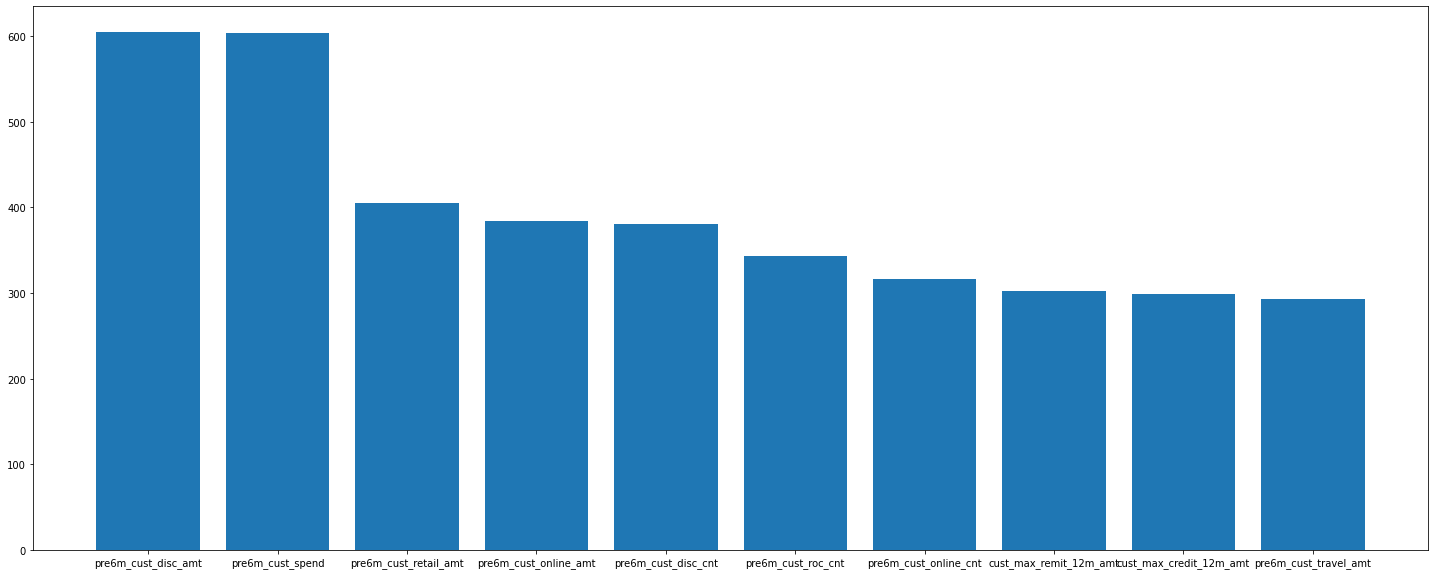

In [29]:
# Plotting the feature importances for the top 10 important numerical columns

plt.figure(figsize = (25, 10))
plt.bar([i for i in range(10)], list(df_imp['ANNOVA'].values[:10]), tick_label = list(df_imp['features'].values[:10]))
plt.show()

In [30]:
df_train_norm = pd.DataFrame()

for column in df_train.columns[:-1]:
  df_train_norm[column] = (df_train[column] - df_train[column].mean())/df_train[column].std()

X = df_train_norm.iloc[:,:-1]
Y = df_train.iloc[:, -1]

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 10)

In [32]:
from sklearn.manifold import TSNE

# tsne = TSNE(n_components = 2, init='pca', random_state = 10)

# X_sne_plot = tsne.fit_transform(X_train)

# X_sne_plot_0 = X_sne_plot[np.where(Y_train == 0)]
# X_sne_plot_1 = X_sne_plot[np.where(Y_train == 1)]

# plt.scatter(X_sne_plot_0[:,0], X_sne_plot_0[:,1], c = 'r')
# plt.scatter(X_sne_plot_1[:,0], X_sne_plot_1[:,1], c = 'b')

# plt.legend(["0", "1"])
# plt.show()

## **Modelling using different algorithms**

In [33]:
# Importing th necessary libraries

import sklearn
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from sklearn.neighbors import KNeighborsClassifier as KNN
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

##### **We will try several supervised classification algorithms on the same dataset, keeping in mind the class imbalance in the dataset**

### **(1) Using SMOTE to resampe as a balanced dataset**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The Precision for the model is 0.2548148148148148
The Recall for the model is 0.7020408163265306
The F1 Score for the model is 0.3739130434782609


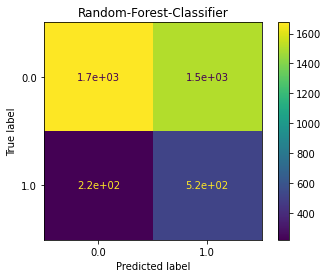

The Precision for the model is 0.22495344506517692
The Recall for the model is 0.8217687074829932
The F1 Score for the model is 0.3532163742690058


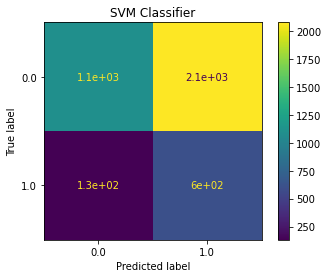

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The Precision for the model is 0.2106948447006084
The Recall for the model is 0.8952380952380953
The F1 Score for the model is 0.34110938310005184


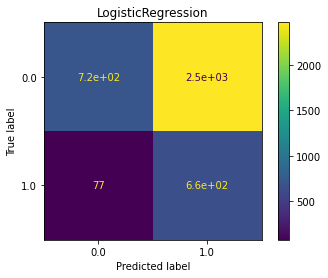

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score  

#Firstly, we will resample the datset, and fit several classifiers on it
sample =  SMOTEENN(sampling_strategy=1, enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_over, Y_over = sample.fit_resample(X_train, Y_train)

###################################

# Using RandoForestClassifier 
from sklearn.ensemble import RandomForestClassifier

model_1= RandomForestClassifier(n_estimators=100)
model_1.fit(X_over, Y_over)
Y_pred_1 = model_1.predict(X_test)

print("The Precision for the model is "+  str(precision_score(Y_test, Y_pred_1)))
print("The Recall for the model is " +  str(recall_score(Y_test, Y_pred_1)))
print("The F1 Score for the model is " +  str(f1_score(Y_test, Y_pred_1)))

plot_confusion_matrix(model_1, X_test, Y_test) 
plt.title('Random-Forest-Classifier')
plt.show()

####################################

# Using SVM classifier for classification
from sklearn.svm import SVC

model_2= SVC()
model_2.fit(X_over, Y_over)
Y_pred_2 = model_2.predict(X_test)

print("The Precision for the model is " +  str(precision_score(Y_test, Y_pred_2)))
print("The Recall for the model is " +  str(recall_score(Y_test, Y_pred_2)))
print("The F1 Score for the model is " +  str(f1_score(Y_test, Y_pred_2)))

plot_confusion_matrix(model_2, X_test, Y_test) 
plt.title('SVM Classifier')
plt.show()

#####################################

# Using Logistic Regression
from sklearn.linear_model import LogisticRegression

model_3 = LogisticRegression()
model_3.fit(X_over, Y_over)
Y_pred_3 = model_3.predict(X_test)

print("The Precision for the model is " +  str(precision_score(Y_test, Y_pred_3)))
print("The Recall for the model is " +  str(recall_score(Y_test, Y_pred_3)))
print("The F1 Score for the model is " +  str(f1_score(Y_test, Y_pred_3)))

plot_confusion_matrix(model_3, X_test, Y_test) 
plt.title('LogisticRegression')
plt.show()

### **(2) Directly using the imalanced dataset, by tweaking the models**

The Precision for the model is 0.25332594235033257
The Recall for the model is 0.6217687074829932
The F1 Score for the model is 0.3599842457660496


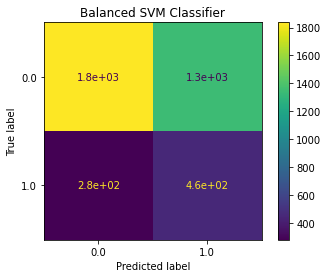

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The Precision for the model is 0.25933831376734257
The Recall for the model is 0.6612244897959184
The F1 Score for the model is 0.3725565350709084


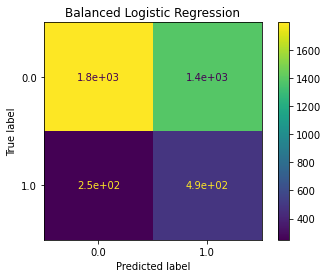

In [ ]:
# Using BalancedRandoForestClassifier for classification, which specifically is from imblearn library, specifically for imbalanced dataset
from imblearn.ensemble import BalancedRandomForestClassifier

# model_1 = BalancedRandomForestClassifier(n_estimators=100)
# model_1.fit(X_train, Y_train)
# Y_pred_1 = model_1.predict(X_test)

# print("The Precision for the model is " + str(precision_score(Y_test, Y_pred_1)))
# print("The Recall for the model is " + str(recall_score(Y_test, Y_pred_1)))
# print("The F1 Score for the model is " + str(f1_score(Y_test, Y_pred_1)))

# plot_confusion_matrix(model_1, X_test, Y_test) 
# plt.title("Balanced Random Forest Classifier")
# plt.show()

###################################################3

# Using Balanced SVM classifier for classification
from sklearn.svm import SVC

""" We can use weighted sum of losses for different classes in SVM classifier, inversly propotional to class ratio """

model_2= SVC(class_weight = "balanced")
model_2.fit(X_over, Y_over)
Y_pred_2 = model_2.predict(X_test)

print("The Precision for the model is " + str(precision_score(Y_test, Y_pred_2)))
print("The Recall for the model is " + str(recall_score(Y_test, Y_pred_2)))
print("The F1 Score for the model is " + str(f1_score(Y_test, Y_pred_2)))

plot_confusion_matrix(model_2, X_test, Y_test) 
plt.title("Balanced SVM Classifier")
plt.show()

####################################################

# Using Balanced Logistic Regression
from sklearn.linear_model import LogisticRegression

model_3 = LogisticRegression(class_weight = 'balanced')
model_3.fit(X_over, Y_over)
Y_pred_3 = model_3.predict(X_test)

print("The Precision for the model is " + str(precision_score(Y_test, Y_pred_3)))
print("The Recall for the model is " + str(recall_score(Y_test, Y_pred_3)))
print("The F1 Score for the model is " + str(f1_score(Y_test, Y_pred_3)))

plot_confusion_matrix(model_3, X_test, Y_test) 
plt.title("Balanced Logistic Regression")
plt.show()

#### **As is visible, --- model performed the best for SMOTEEN resampled dataset; whereas ---- model performed best on the original imbalanced dataset. Hence, we will perform hyper parameter tuning on just that model, and try to squeeze out the best results from the model**

In [ ]:
# model = RandomForestClassifier(n_estimators = 100)
# sample =  SMOTEENN(sampling_strategy=1, enn=EditedNearestNeighbours(sampling_strategy='majority'))
# steps = [('sample', sample), ('model', model)]
# pipeline = Pipeline(steps=steps)

# # evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
# scores = cross_val_score(pipeline, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC score: %.3f' % mean(scores))

In [ ]:
# Checking the ROC-AUC curve for the best performing model (SMOTEEN + RandomForestClassfier)

# sample =  SMOTEENN(sampling_strategy=1, enn=EditedNearestNeighbours(sampling_strategy='majority'))
# X_over, Y_over = sample.fit_resample(X_train, Y_train)

# model= RandomForestClassifier(n_estimators=100)
# model.fit(X_over, Y_over)

# from sklearn.metrics import plot_roc_curve

# plot_roc_curve(model, X_test, Y_test) 
# plt.show()

## **Using GANs for creating synthetic minority dataset**

In [34]:
import numpy as np
from matplotlib import pyplot as plt

In [35]:
X_train = X_train.values
Y_train = Y_train.values

In [36]:
temp_list = []

idx = np.where(Y_train == 1)

for t in idx[0]:
  temp_list.append(X_train[t,:])

X_GAN = np.vstack(temp_list)

In [37]:
from keras.models import Sequential
from keras.layers import Dense

In [38]:
def define_discriminator():
  model = Sequential()
  model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_dim=X_GAN.shape[-1]))
  model.add(Dense(80, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [39]:
def define_discriminator():
  model = Sequential()
  model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_dim=X_GAN.shape[-1]))
  model.add(Dense(150, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(80, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [40]:
def define_generator():
  model = Sequential()
  model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_dim=X_GAN.shape[-1]))
  model.add(Dense(150, activation='relu'))
  model.add(Dense(150, activation='relu'))
  model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(X_GAN.shape[-1], activation='linear'))

  return model

In [41]:
def define_generator():
  model = Sequential()
  model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_dim=X_GAN.shape[-1]))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(120, activation='relu'))
  model.add(Dense(120, activation='relu'))
  model.add(Dense(150, activation='relu'))
  model.add(Dense(150, activation='relu'))
  model.add(Dense(120, activation='relu'))
  model.add(Dense(120, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
  model.add(Dense(X_GAN.shape[-1], activation='linear'))

  return model

In [42]:
# define the combined generator and discriminator model, for updating the generator

def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [43]:
# generate n real samples with class labels
def generate_real_samples(n):
  temp_list = []
  for i in range(n):
	  temp_list.append(X_GAN[int(np.random.randint(X_GAN.shape[0], size=1)),:])
  return np.vstack(temp_list), np.ones((n, 1))

# generate points in latent space as input for the generator
def generate_latent_points(n):
  # generate points in the latent space
	x_input = np.random.randn(X_GAN.shape[-1] * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, X_GAN.shape[1])
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, n):
	# generate points in latent space
	x_input = generate_latent_points(n)
	# predict outputs
	X = generator.predict(x_input)
	return X, np.zeros((n, 1))

In [44]:
# # evaluate the discriminator and plot real and fake points
# def summarize_performance(epoch, generator, discriminator, n=100):
# 	# prepare real samples
# 	x_real, y_real = generate_real_samples(n)
# 	# evaluate discriminator on real examples
# 	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
# 	# prepare fake examples
# 	x_fake, y_fake = generate_fake_samples(generator, n)
# 	# evaluate discriminator on fake examples
# 	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
# 	# summarize discriminator performance
# 	print(epoch, acc_real, acc_fake)
# 	# scatter plot real and fake data points
# 	plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
# 	plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
# 	plt.show()


# # train the generator and discriminator
# def train(g_model, d_model, gan_model, n_epochs=10000, n_batch=128, n_eval=2000):
# 	# determine half the size of one batch, for updating the discriminator
# 	half_batch = int(n_batch / 2)
# 	# manually enumerate epochs
# 	for i in range(n_epochs):
# 		# prepare real samples
# 		x_real, y_real = generate_real_samples(half_batch)
# 		# prepare fake examples
# 		x_fake, y_fake = generate_fake_samples(g_model, half_batch)
# 		# update discriminator
# 		d_model.train_on_batch(x_real, y_real)
# 		d_model.train_on_batch(x_fake, y_fake)
# 		# prepare points in latent space as input for the generator
# 		x_gan = generate_latent_points(n_batch)
# 		# create inverted labels for the fake samples
# 		y_gan = np.ones((n_batch, 1))
# 		# update the generator via the discriminator's error
# 		gan_model.train_on_batch(x_gan, y_gan)
# 		# evaluate the model every n_eval epochs

In [45]:
# Finding out the columns with maximum correlation

df_GAN = pd.DataFrame(X_GAN)

np_corr = df_GAN.corr().replace(1, -10000).values
idx = np.argmax(np_corr)

col1 = int(idx/np_corr.shape[1])
col2 = idx - (col1 * np_corr.shape[1])

print(col1)
print(col2)

#Sanity Check
assert np_corr[col1, col2] == np.max(np_corr)

38
39


In [54]:
def summarize_performance(epoch, generator, discriminator, n_eval, axs, n=100):

  x_real, y_real = generate_real_samples(n)
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(generator, n)
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

  print(epoch)

  tsne = TSNE(n_components = 2, init='pca', random_state = 10)
  X_sne_plot_real = tsne.fit_transform(x_real)

  tsne = TSNE(n_components = 2, init='pca', random_state = 10)
  x_sne_plot_fake = tsne.fit_transform(x_fake)

  axs[int((epoch+1)/n_eval)][0].scatter(X_sne_plot_real[:,0], X_sne_plot_real[:,1], c = 'r')
  axs[int((epoch+1)/n_eval)][1].scatter(x_sne_plot_fake[:,0], x_sne_plot_fake[:,1], c = 'b')

  # return x_real, x_fake

def train(g_model, d_model, gan_model, n_epochs=10000, n_batch=128,  n_eval=2000):
  
  fig, axs = plt.subplots(nrows = int(n_epochs/n_eval) + 1, ncols = 2, figsize=(15, 40))
  
  half_batch = int(n_batch / 2)

  for i in range(n_epochs):
    x_real, y_real = generate_real_samples(half_batch)
    x_fake, y_fake = generate_fake_samples(g_model, half_batch)

    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)

    x_gan = generate_latent_points(n_batch)
    y_gan = np.ones((n_batch, 1))

    gan_model.train_on_batch(x_gan, y_gan)

    if (i+1) % n_eval == 0:
      summarize_performance(i, g_model, d_model, n_eval, axs)
    else:
      pass

  plt.show()

1999
3999
5999
7999
9999


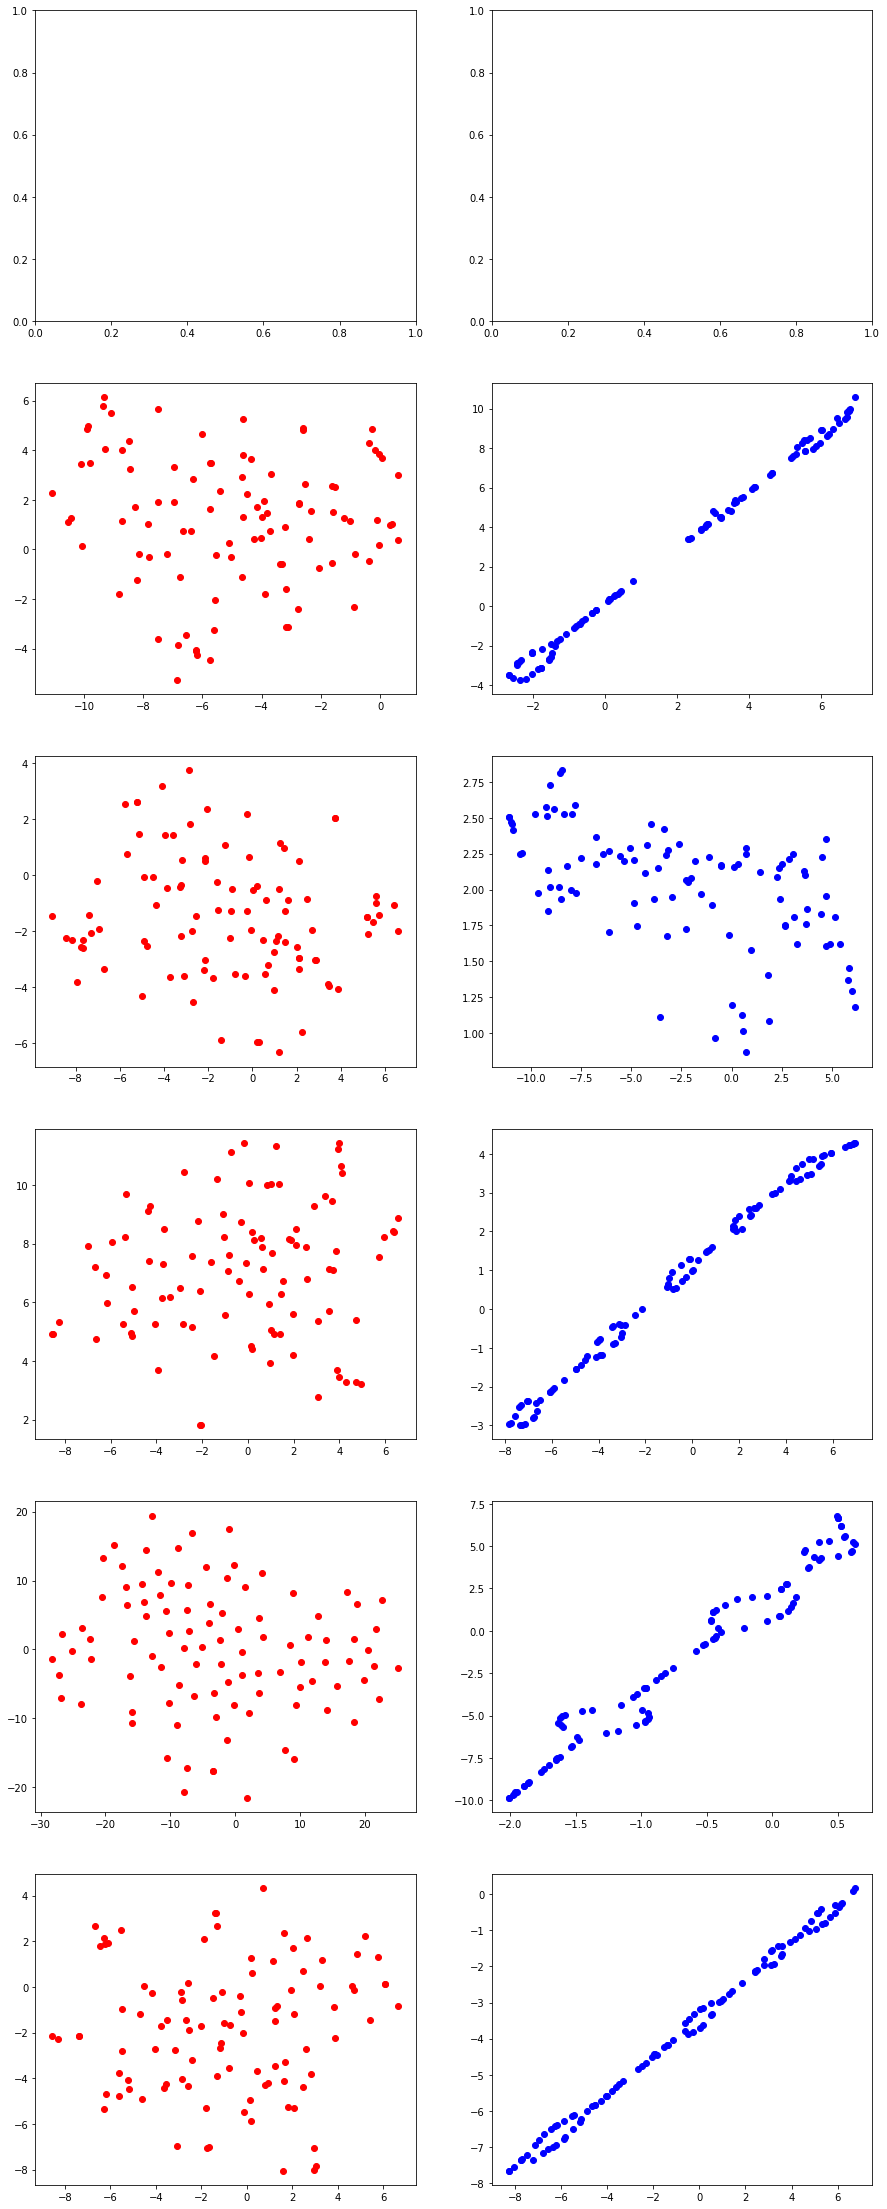

In [55]:
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator()
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model)

In [ ]:
generator.save("generator.")

In [ ]:
x_fake, y_fake = generate_fake_samples(generator, n=100)

tsne = TSNE(n_components = 2, init='pca', random_state = 10)
x_sne_plot_fake = tsne.fit_transform(x_fake)

In [ ]:
plt.scatter(x_sne_plot_fake[:,0], x_sne_plot_fake[:,1], c = 'b')